In [20]:
from transformers import (
    Blip2VisionConfig,
    Blip2VisionModel,
    Blip2QFormerConfig,
    OPTConfig,
    Blip2Config,
    Blip2ForConditionalGeneration,
    AutoProcessor
)

import numpy as np
from PIL import Image
import torch
import cv2
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt 
import torchvision.datasets as datasets
from tqdm import tqdm
from pathlib import Path 
import matplotlib.pyplot as plt 

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Helper function to de-normalize the cifar image from (0,1) to (0,255) range

In [16]:
def interval_mapping(image, from_min, from_max, to_min, to_max):
    # map values from [from_min, from_max] to [to_min, to_max]
    # image: input array
    from_range = from_max - from_min
    to_range = to_max - to_min
    scaled = np.array((image - from_min) / float(from_range), dtype=float)

    return to_min + (scaled * to_range)

Loading DIV2K dataset 

In [17]:
root = Path('/Users/akhilbaweja/Desktop/Winter Assignments/805/project/data/DIV2K_valid_HR/')
image_type = 'png'
val_imgfiles = sorted(list(root.glob(f'*.{image_type}')))

In [6]:
torch.manual_seed(43)

Visualizing image from the dataset.

1.0 0.0


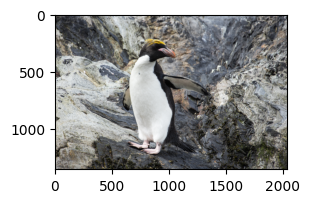

In [22]:
for images in val_imgfiles:
    image = plt.imread(images)
    print(image.max(), image.min())
    plt.figure(figsize=(3,3))
    plt.imshow(image)
    plt.show()
    break

Loading BLIP-2 model from hugginface and initializing an instance of it

In [8]:
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading model to gpu

In [11]:
model.to(device)

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

Predicting textual descriptions and saving results in batches into a .txt file

In [31]:
samples_desc = []
sample_imgs = []
for imgpath in val_imgfiles:
    img = plt.imread(imgpath)
    de_norm = interval_mapping(img, 0.0, 1.0, 0, 255).astype('uint8') 
    image = np.array(de_norm)
    sample_imgs.append(image)
    inputs = processor(image, return_tensors="pt").to(device, torch.float16)

    generated_ids = model.generate(**inputs, max_new_tokens=20)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    samples_desc.append(generated_text)

In [23]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(sample_imgs[0])
axarr[0,0].set_title(samples_desc[0], fontsize=6)
axarr[0,1].imshow(sample_imgs[1])
axarr[0,1].set_title(samples_desc[1], fontsize=6)
axarr[1,0].imshow(sample_imgs[2])
axarr[1,0].set_title(samples_desc[2], fontsize=6)
axarr[1,1].imshow(sample_imgs[3])
axarr[1,1].set_title(samples_desc[3], fontsize=6)
f.tight_layout()
f.show()

In [13]:
text_desc_train = []
for count, imgpath in tqdm(enumerate(val_imgfiles)):
    img = plt.imread(imgpath)
    de_norm = interval_mapping(img, 0.0, 1.0, 0, 255).astype('uint8') 
    image = np.array(de_norm)
    inputs = processor(image, return_tensors="pt").to(device, torch.float16)

    generated_ids = model.generate(**inputs, max_new_tokens=20)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    text_desc_train.append(generated_text)

45000it [3:30:47,  3.56it/s]


Writing list of texts in a text file

In [14]:
with open('textual_descriptions_train.txt', 'w') as f:
    for line in text_desc_train:
        f.write(f"{line}\n")

In [ ]:
# text_desc_val = []
# for images in tqdm(val_ds):
#     image = np.array(images[0])
#     image = upsample_and_denormalize(image)
#     inputs = processor(image, return_tensors="pt").to(device, torch.float16)

#     generated_ids = model.generate(**inputs, max_new_tokens=20)
#     generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
#     text_desc_val.append(generated_text)

100%|██████████| 5000/5000 [23:17<00:00,  3.58it/s]


In [16]:
# with open('textual_descriptions_val.txt', 'w') as f:
#     for line in text_desc_val:
#         f.write(f"{line}\n")